In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

In [2]:
거래정보 = pd.read_csv("거래 정보.CSV", engine = 'python')

In [3]:
거래정보.columns = ['클라이언트ID', '거래ID', '거래일련번호', '업종단위', '상품소분류코드', '구매일자', '구매시각', '구매금액', '구매수량']

In [4]:
온라인정보 = pd.read_csv("온라인 행동 정보.CSV", engine = 'python')

In [5]:
온라인정보.columns = ['클라이언트ID', '세션ID', '조회일련번호', '행동유형', '업종단위', 
                 '세션일자', '조회시각','조회경과시간', '거래ID', '검색 키워드',
                '총페이지조회건수', '총세션시간값', '유입채널', '기기유형']

### 거래소비자 / 거래안한 소비자 나누기

In [6]:
거래_클라이언트ID = 거래정보['클라이언트ID'].unique()

거래한소비자인덱스 = 온라인정보['클라이언트ID'][온라인정보['클라이언트ID'].isin(거래_클라이언트ID) == True].index

거래안한소비자인덱스 = 온라인정보['클라이언트ID'][온라인정보['클라이언트ID'].isin(거래_클라이언트ID) == False].index

거래소비자 = 온라인정보.loc[거래한소비자인덱스]

거래안한소비자 = 온라인정보.loc[거래안한소비자인덱스]

### 거래안한 소비자 중 신중한 소비자를 보일 수 있는 변수를 만들어보자
- 조회경과시간

In [7]:
삭제 = [10437, 10447, 10787, 12121, 12147, 12866,  1292,  1336, 13622,
       13694, 13706, 14286, 15479, 15694, 15767,  1646, 16637, 17853,
       19451, 19605, 19758, 20133, 22214, 22692,  2326, 23527, 24267,
       24544, 24564, 26139, 26926, 28409, 29076, 29218, 30106, 30710,
       31970, 32135, 33651, 34169, 34454, 34838, 35420, 36267,  3696,
       37535,  3754, 37787, 38734, 41548, 41597, 44113, 44901,  4581,
       46603, 47476, 47645,  4797, 49111, 50045, 50915, 51223, 52926,
       53656, 56225, 57037, 57236, 57774,  5823, 58434, 58895, 58926,
       59490, 59900, 61825, 63286, 64643, 64832, 64874,  6550, 65587,
        6629, 66463, 67836, 68206, 68255, 70503, 70793, 72287,  7423,
        7867,  7948,  8007,  9710,  9761]

In [8]:
# 거래ID는 있지만 TYPE  = 6은 없는 소비자 제거

for a in 삭제:
    거래소비자.drop(거래소비자[거래소비자['클라이언트ID'] ==a].index, inplace = True)

In [9]:
from tqdm import tqdm

In [10]:
거래까지조회경과시간 = 거래소비자[거래소비자['행동유형']== 6].pivot_table(index = ['클라이언트ID'], aggfunc = 'max', values = '조회경과시간').reset_index()

In [11]:
배성 = pd.read_csv("배성.CSV", engine = 'python')

In [12]:
배성.columns = ['클라이언트ID', '총페이지개수_max', '총세션시간_max', 'Back_nums']

In [13]:
거래소비자_예민도 = pd.merge(배성, 거래까지조회경과시간, on = '클라이언트ID', how = 'right')

In [15]:
검색어연관도 = pd.read_csv("검색어연관도.CSV", engine = 'python')

In [16]:
검색어연관도.columns = ['Unnamed: 0', '클라이언트ID','검색어연관도']

In [17]:
신중도 = pd.merge(검색어연관도, 거래소비자_예민도, on = '클라이언트ID', how = 'right')

In [18]:
신중도.drop('Unnamed: 0', axis = 1, inplace = True)

In [19]:
신중도.columns = ['클라이언트ID','검색어연관도','총페이지개수_max','총세션시간_max','Back_nums','구매까지_조회경과시간']

In [20]:
신중도 = 신중도.dropna(axis = 0, subset = ['검색어연관도'])

In [21]:
신중도 = 신중도.reset_index()

### 스케일링

In [22]:
# RobustScaler
from sklearn.preprocessing import RobustScaler

robustScaler = RobustScaler()
robustScaler.fit(신중도[['Back_nums', '구매까지_조회경과시간', '검색어연관도']])
train_data_robustScaled = robustScaler.transform(신중도[['Back_nums', '구매까지_조회경과시간', '검색어연관도']])

In [23]:
robust_Scale = pd.DataFrame(train_data_robustScaled)
robust_Scale.columns = ['Back_nums_robust_Scale', '구매까지_조회경과시간_robust_Scale', '검색어연관도_robust_Scale']

In [24]:
from sklearn.preprocessing import MinMaxScaler

minMaxScaler = MinMaxScaler()
minMaxScaler.fit(신중도[['Back_nums', '구매까지_조회경과시간', '검색어연관도']])
train_data_minMaxScaled = minMaxScaler.transform(신중도[['Back_nums', '구매까지_조회경과시간', '검색어연관도']])

In [25]:
MinMax_Scale = pd.DataFrame(train_data_minMaxScaled)
MinMax_Scale.columns = ['Back_nums_Min/Max_Scale', '구매까지_조회경과시간_Min/Max_Scale', '검색어연관도_Min/Max_Scale']

In [26]:
거래소비자__신중도 = pd.concat([신중도, MinMax_Scale, robust_Scale], axis = 1)

In [27]:
거래소비자__신중도.head()

,index,클라이언트ID,검색어연관도,총페이지개수_max,총세션시간_max,Back_nums,구매까지_조회경과시간,Back_nums_Min/Max_Scale,구매까지_조회경과시간_Min/Max_Scale,검색어연관도_Min/Max_Scale,Back_nums_robust_Scale,구매까지_조회경과시간_robust_Scale,검색어연관도_robust_Scale
0,0,5535,9.0,80.0,2410.0,3.818182,2384702,0.093126,0.158781,0.002191,0.294969,0.415291,0.090909
1,1,29126,2.0,12.0,356.0,0.400000,199077,0.009756,0.013253,0.000487,-0.580624,-0.724813,-0.227273
2,2,33973,5.0,103.0,3619.0,12.333333,682172,0.300813,0.045419,0.001217,2.476190,-0.472812,-0.090909
3,3,43059,7.0,179.0,4078.0,0.250000,877087,0.006098,0.058398,0.001704,-0.619048,-0.371137,0.000000
4,4,20952,16.0,30.0,2489.0,2.400000,1152751,0.058537,0.076753,0.003895,-0.068309,-0.227341,0.409091


In [28]:
import matplotlib as mpl

mpl.rcParams['font.family'].insert(0, 'Malgun Gothic')

In [29]:
feature_MinMax_Scale= 거래소비자__신중도[ ['Back_nums_Min/Max_Scale', '구매까지_조회경과시간_Min/Max_Scale', '검색어연관도_Min/Max_Scale']]
feature_MinMax_Scale.head()

,Back_nums_Min/Max_Scale,구매까지_조회경과시간_Min/Max_Scale,검색어연관도_Min/Max_Scale
0,0.093126,0.158781,0.002191
1,0.009756,0.013253,0.000487
2,0.300813,0.045419,0.001217
3,0.006098,0.058398,0.001704
4,0.058537,0.076753,0.003895


In [30]:
feature_robust_Scale = 거래소비자__신중도[ ['Back_nums_robust_Scale', '구매까지_조회경과시간_robust_Scale', '검색어연관도_robust_Scale']]
feature_robust_Scale.head()

,Back_nums_robust_Scale,구매까지_조회경과시간_robust_Scale,검색어연관도_robust_Scale
0,0.294969,0.415291,0.090909
1,-0.580624,-0.724813,-0.227273
2,2.476190,-0.472812,-0.090909
3,-0.619048,-0.371137,0.000000
4,-0.068309,-0.227341,0.409091


In [31]:
from sklearn.cluster import KMeans

ks = range(1, 10)

inertias = []
score = []

for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(feature_robust_Scale)
    inertias.append(model.inertia_)  # inertia_=> 응집도 계산해주는 내장함수
    score.append(model.score(feature_robust_Scale))
    
inertias  # 응집도 값 계산
#score

[179715.70106950228,
 78598.28302520787,
 47777.84692013106,
 35378.46174493445,
 27895.969185942624,
 22463.548882110706,
 18097.465460888227,
 14807.204970033725,
 12709.027826960431]

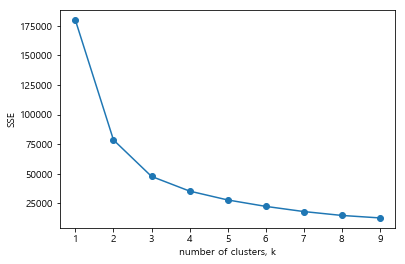

In [32]:
# 회차당 응집도 그래프 그리기
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('SSE')
plt.xticks(ks)
plt.show()

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns

# create model and prediction
model = KMeans(n_clusters=3,algorithm='auto')
model.fit(feature_robust_Scale)
predict = pd.DataFrame(model.predict(feature_robust_Scale))
#print(predict)
predict.columns=['predict']  # predcit는 군집에 라벨링해주는 것
                             # 이 데이터는 군집0, 군집1, 군집2에 들어간다 

# concatenate labels to df as a new column
r = pd.concat([feature_robust_Scale,predict],axis=1)

print(r)

      Back_nums_robust_Scale  구매까지_조회경과시간_robust_Scale  검색어연관도_robust_Scale  \
0                   0.294969                  0.415291             0.090909   
1                  -0.580624                 -0.724813            -0.227273   
2                   2.476190                 -0.472812            -0.090909   
3                  -0.619048                 -0.371137             0.000000   
4                  -0.068309                 -0.227341             0.409091   
5                   0.017976                  0.150440             0.590909   
6                   0.567565                  0.460497             1.045455   
7                  -0.669605                  1.166442             3.318182   
8                  -0.085386                  1.890764             4.863636   
9                   0.462088                  0.172876             2.318182   
10                  0.683087                 -0.473866            -0.136364   
11                 -0.490969                 -0.7377

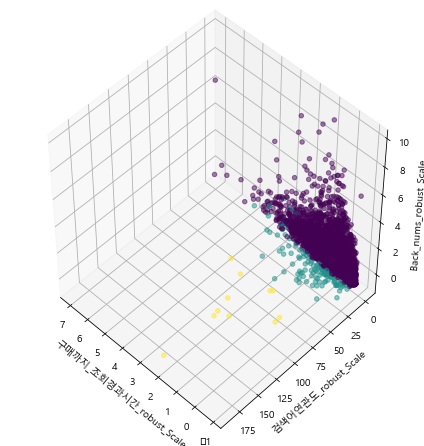

In [34]:
from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure( figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['구매까지_조회경과시간_robust_Scale'],r['검색어연관도_robust_Scale'],r['Back_nums_robust_Scale'], c=r['predict'],alpha=0.5)
ax.set_xlabel('구매까지_조회경과시간_robust_Scale')
ax.set_ylabel('검색어연관도_robust_Scale')
ax.set_zlabel('Back_nums_robust_Scale')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


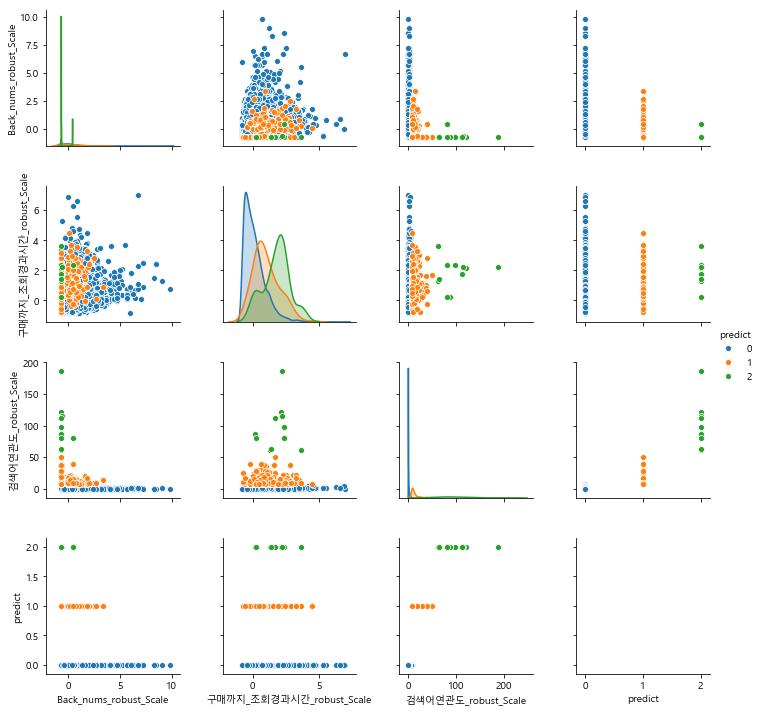

In [35]:
#pairplot with Seaborn
sns.pairplot(r, hue='predict')
plt.show()

In [36]:
from sklearn.cluster import KMeans

ks = range(1, 10)

inertias = []
score = []

for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(feature_MinMax_Scale)
    inertias.append(model.inertia_)  # inertia_=> 응집도 계산해주는 내장함수
    score.append(model.score(feature_MinMax_Scale))
    
inertias  # 응집도 값 계산
#score

[157.75419077439585,
 92.07846854087738,
 67.68252978888356,
 51.76037814724072,
 42.18636294550279,
 36.06803514980604,
 31.743277277976258,
 28.81223306839607,
 26.06399453167851]

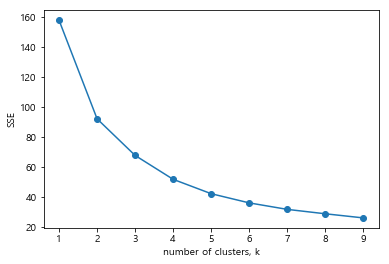

In [37]:
# 회차당 응집도 그래프 그리기
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('SSE')
plt.xticks(ks)
plt.show()

In [38]:
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns

# create model and prediction
model = KMeans(n_clusters=3,algorithm='auto')
model.fit(feature_MinMax_Scale)
predict = pd.DataFrame(model.predict(feature_MinMax_Scale))
#print(predict)
predict.columns=['predict']  # predcit는 군집에 라벨링해주는 것
                             # 이 데이터는 군집0, 군집1, 군집2에 들어간다 

# concatenate labels to df as a new column
r = pd.concat([feature_MinMax_Scale,predict],axis=1)

print(r)

      Back_nums_Min/Max_Scale  구매까지_조회경과시간_Min/Max_Scale  \
0                    0.093126                   0.158781   
1                    0.009756                   0.013253   
2                    0.300813                   0.045419   
3                    0.006098                   0.058398   
4                    0.058537                   0.076753   
5                    0.066752                   0.124974   
6                    0.119082                   0.164552   
7                    0.001284                   0.254662   
8                    0.056911                   0.347118   
9                    0.109039                   0.127838   
10                   0.130081                   0.045285   
11                   0.018293                   0.011606   
12                   0.034146                   0.006481   
13                   0.073171                   0.133993   
14                   0.002251                   0.317682   
15                   0.025745           

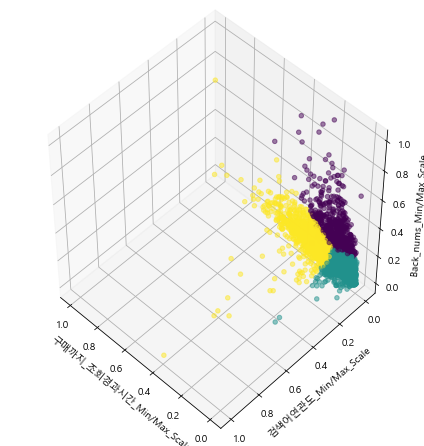

In [39]:
from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure( figsize=(6,6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(r['구매까지_조회경과시간_Min/Max_Scale'],r['검색어연관도_Min/Max_Scale'],r['Back_nums_Min/Max_Scale'], c=r['predict'],alpha=0.5)
ax.set_xlabel('구매까지_조회경과시간_Min/Max_Scale')
ax.set_ylabel('검색어연관도_Min/Max_Scale')
ax.set_zlabel('Back_nums_Min/Max_Scale')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


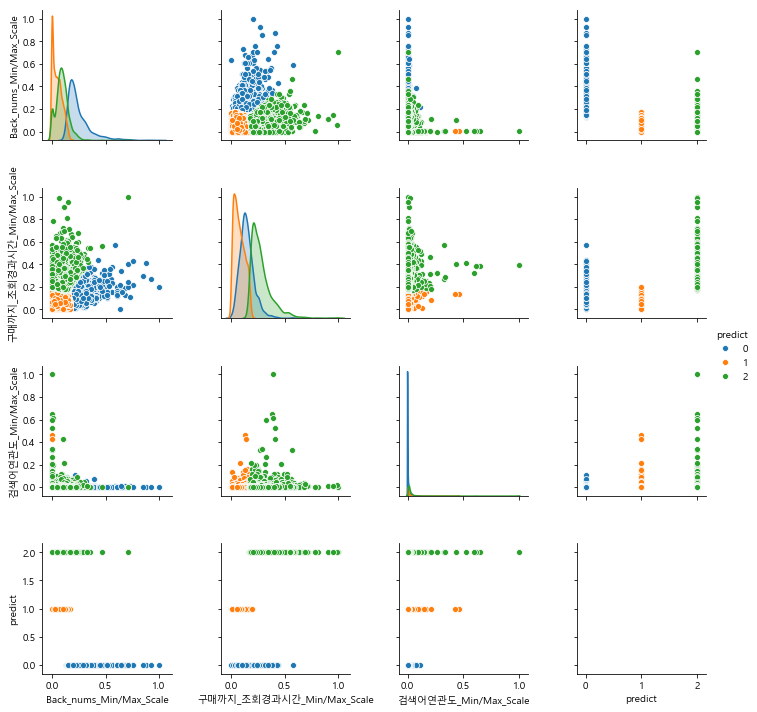

In [40]:
#pairplot with Seaborn
sns.pairplot(r, hue='predict')
plt.show()